In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [80]:
from compute import Var, Par
from datastructures.api import Model, adda, addf, addsolver, setsolvefor
from datastructures.execution import edges_from_components
from datastructures.graphutils import namefromsympy, dfs_tree, SOLVER, VAR, COMP, nested_sources, sources, edges_to_Ein_Eout, flat_graph_formulation, root_solver
from datastructures.nestedgraph import root_sources
from datastructures.execution import generate_components_and_residuals
from datastructures.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.operators import sort_scc, reorder_merge_solve
from datastructures.assembly import build_archi
import openmdao.api as om
from datastructures.api import evalexpr
from collections import OrderedDict
import matplotlib.pyplot as plt

In [3]:
from sympy import cos, pi

# Mahas formulation with residuals

In [4]:
Df = Var('D_f', 2, unit='m')
Ds = Var('D_s', 1, unit='m')
Dd = Var('D_d', 1.25, unit='m')
tf = Var('t_f', 0.5, unit='m')
ts = Var('t_s', 2, unit='m')
td = Var('t_d', 0.5, unit='m')

In [5]:
rhow = Par(r'\rho_w', 1023.6, 'kg/m^3') # density of seawater [kg/m^3]
rho = Var(r'\rho', 700, 'kg/m^3')       # arbitrarily set
rhoh = Var(r'\rho_h', 2700, 'kg/m^3')   # arbitrarily set

In [6]:
model = Model()
m = model.root

## Mass budget

In [7]:
Vtot = adda(m, 'Vtot', pi/4*(Df**2*tf+Ds**2*ts+Dd**2*td))
mstruct = adda(m, 'm_{struct}', pi/4*(Df**2*tf*rho+Ds**2*ts*rho+Dd**2*td*rhoh)) # mass of structure

In [8]:
mbatt = Var('m_{batt}', unit='kg')
eta_solar = Par(r'\eta_{solar}', 10, 'kg/m^2')
A_s = Var('A_{solar}', unit='m^2')
msolar = adda(m, 'm_{solar}', eta_solar*A_s)
mprop = Par('m_{prop}', 50, 'kg') # mass of propulsion
mcomms = Par('m_{comms}', 50, 'kg') # mass of comms system
mtot = adda(m, 'm_{platform}', mbatt+msolar+mcomms+mprop+mstruct) 
g = Par('g', 9.81, 'm/s^2')
FW = adda(m, 'F_W', mtot*g, 'N')

## Hydrostatic stability

In [9]:
#hf = Var('h_f', 0.5, 'm')

In [10]:
#Vd = adda(m, 'Vd', pi/4*(Df**2*hf+Ds**2*ts+Dd**2*td))
Vd = adda(m, 'Vd', mtot/rhow) #shortcut for now
FB = adda(m, 'F_B', rhow*Vd*g, unit='N')

In [11]:
hf = adda(m, 'h_f', (4*Vd/pi-Ds**2*ts-Dd**2*td)/Df**2)

In [12]:
(4*Vd/pi-Ds**2*ts-Dd**2*td)/Df**2

(-D_d**2*t_d - D_s**2*t_s + 4*Vd/pi)/D_f**2

In [13]:
hf

h_f

In [14]:
xd = td/2
xs = td+ts/2
xf1 = td+ts+hf/2
xf2 = td+ts+tf/2
totA1 = hf*Df+ts*Ds+td*Dd
totA2 = tf*Df+ts*Ds+td*Dd

In [15]:
KB = adda(m, 'K_B', (hf*Df*xf1+ts*Ds*xs+td*Dd*xd)/totA1) # z_B

In [16]:
KG = adda(m, 'K_G', (tf*Df*xf2+ts*Ds*xs+td*Dd*xd)/totA2) 
#z_G = KG-hf-td-ts

In [17]:
KB

K_B

In [18]:
KG

K_G

In [19]:
I = adda(m, 'I', pi/64*Df**4)

In [20]:
BM = adda(m, 'B_M', I/Vd)

In [21]:
BM

B_M

In [22]:
GM = adda(m, "G_M", KB+BM-KG) #should be 3-5% according to http://web.mit.edu/13.012/www/handouts/Reading3.pdf

In [23]:
GM

G_M

In [24]:
#addf(m, GM-0.05*Df)
#setsolvefor(m, [td])

## Power recharge

In [25]:
eta_A = Par(r'\eta_A', 0.75) #coverage fraction for solar panels
addf(m, A_s-eta_A*pi*(Df/2)**2)
setsolvefor(m, [Df])

In [26]:
eta_s = Par(r'\eta_s', 0.27)
phi_s = Par(r'\phi_s', 800, 'W/m**2')
theta_bar = Par(r'\theta', 55, 'deg')
Ideg = Par('I_{deg}', 0.9)
ddeg = Par('d_{deg}', 0.005)
Lsolar = Par('L_{solar}', 10) #lifetime in years, but units acts weirdly in powers

In [27]:
P_recharge = adda(m, r'P_{recharge}', 
    eta_s * phi_s * cos(theta_bar) * Ideg * (1-ddeg)**Lsolar * A_s, unit='W', forceunit=True)

In [28]:
P_recharge

P_{recharge}

## Propulsion

In [29]:
C_d = Par('C_d', 1) # estimate drag coefficient (a square flat plate at 90 deg to the flow is 1.17)
S_w = Par('S_w', 10, 'm**2') # wetted surface
v = Var('v', 1, unit='m/s') # [m/s]
eta_m = Par(r'\eta_m', 0.75) # estimated, need to determine from motors?
P_move = adda(m, 'P_{move}', rhow*C_d*S_w*v**3/(2*eta_m), unit='W')

In [30]:
P_move

P_{move}

## Energy budget

In [31]:
# should t_move, t_comms, t_service and t_recharge add up to 24 hours?
t_mission = Par('t_{mission}', 24, 'hr')
t_comms = Par('t_{comms}', 1, 'hr')
t_move = Par('t_{move}', 1, 'hr')
t_service = Par('t_{service}', 12, 'hr')
t_recharge = Par('t_{recharge}', 12, 'hr')

In [32]:
E_move = adda(m, 'E_{move}', P_move*t_move, unit='kW*hr')
P_hotel = Par('P_{hotel}', 50, 'W')
E_hotel = adda(m, 'E_{hotel}', P_hotel*t_mission, unit='kW*hr')
Pcomms = Var('P_{comms}', 0.5, 'W')
E_comms = adda(m, 'E_{comms}', Pcomms*t_comms, unit='W*hr')
E_AUV = Par('E_{AUV}', 1.9, 'kW*hr') # AUV battery capacity (to be recharged), based on Bluefin-9
gamma = Par(r'\gamma', 1) # AUVs serviced per mission duration (aka in the time of t_mission)
E_service = adda(m, 'E_{service}', E_AUV * gamma, unit='kW*hr')
P_service = adda(m, 'P_{service}', E_service/t_service, unit='W')

In [33]:
E_required = adda(m, 'E_{required}', E_hotel+E_move+E_service+E_comms, unit='kW*hr')
E_recharge = adda(m, 'E_{recharge}', P_recharge * t_recharge, unit='kW*hr')

In [34]:
E_required

E_{required}

In [35]:
E_recharge

E_{recharge}

In [36]:
addf(m, E_required-E_recharge)

23

In [37]:
setsolvefor(m, [A_s])

In [38]:
#P_drawrecharge = adda(m, 'P_{drawrecharge}', P_hotel - P_recharge) #can be negative
#P_drawservice = adda(m, 'P_{drawservice}', P_hotel + P_service)
#P_drawmove = adda(m, 'P_{drawmove}', P_hotel+P_move)
#P_drawcomms = adda(m, 'P_{drawcomms}', P_hotel+P_comms)

## Battery

In [39]:
mu_batt = Par(r'\mu_{battery}', 200, 'W*hr/kg') # Lithium ion
DOD = Par('DOD', 0.7)
eta_batt = Par(r'\eta_{battery}', 0.85) # transmission efficiency
nu_batt = Par(r'\nu_{battery}', 450, 'kW*hr/(m**3)')
N = Par('N', 1)
C = adda(m, 'C', E_required/(DOD*N*eta_batt), unit='kW*hr')
V_batt = adda(m, 'V_{batt}', C/nu_batt, unit='m**3')
m_batt_zero = Par('m_{batt_zero}', 5, 'kg')
adda(m, mbatt, C/mu_batt + m_batt_zero, unit='kg') # was already defined in the beginning

m_{batt}

## Communication Systems

In [40]:
import sympy as sp
db2dec = lambda x: 10**(x/10)
dec2db = lambda x: 10*sp.log(sp.Abs(x), 10)

In [41]:
k = Par('k', 1.38065e-23, 'J/K')
c = Par('c', 3e8, 'm/s')
f = Par('f', 2.2, 'GHz')

In [42]:
Lambda = adda(m, r'\lambda', c/f, unit='m')

In [43]:
eta_parab = Par(r'\eta_{parab}', 0.55)
theta_t = Par(r'\theta_t', 32)
error_t = Par('e_t', 27)

In [44]:
G_pt_db = adda(m, 'G_{pt}', 44.3-dec2db(theta_t**2), forceunit=True)

In [45]:
L_pt_db = adda(m, 'L_{pt_db}', -12*(error_t/theta_t)**2)

In [46]:
G_t = adda(m, 'G_t', db2dec(G_pt_db+L_pt_db))

In [47]:
D_r = Par('D_r', 5.3, 'm')
G_r = adda(m, 'G_r', eta_parab*(pi*D_r/Lambda)**2)

In [48]:
h = Par('h', 780, 'km')
Re = Par('Re', 6378, 'km')
S = adda(m, 'S', sp.sqrt(h*(h+2*Re)), unit='km', forceunit=True)

In [49]:
L_s = adda(m, 'L_s', (Lambda/(4*pi*S))**2)

In [50]:
L_s

L_s

In [51]:
BER = Par('BER', 0.0001)
R = Var('R', 10, 'Mbit/s') # 1 per microseconds
T_s = Par('T_s', 135, 'K')
L_a = Par('L_a', db2dec(-0.3))
L_l = Par('L_l', db2dec(-1))
L_p = Par('L_p', db2dec(-0.1))
EN = adda(m, 'EN', Pcomms*L_a*L_s*L_l*L_p*G_r*G_t/(k*T_s*R))

In [52]:
EN

EN

## Hydrodynamics

In [53]:
C33 = adda(m, 'C_{33}', pi*rhow*g/4*Df**2)

In [54]:
A33 = adda(m, 'A_{33}', 0.0525*pi*rhow*(Dd**3+Ds**3+Df**3))

In [55]:
omega0 = adda(m, r'\omega_0', (C33/(A33+mtot))**1/2, unit='rad/s', forceunit=True)

In [56]:
omega0

\omega_0

# HDSM

In [57]:
edges, tree = model.generate_formulation()

In [66]:
nodetyperepr = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
G = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)

In [68]:
topo_order = sort_scc(G)

In [76]:
F_ordered = OrderedDict([(next(iter(comp)).name,1) for comp in topo_order])
ntree = F_ordered, tree[1], tree[2]

In [58]:
from datastructures.graphutils import namefromid
from datastructures.rendering import render_incidence

In [62]:
nodetyperepr2 = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc2 = namefromid(nodetyperepr2)

In [63]:
Ein, Eout, Rin = edges

In [64]:
Ein_noparam = {comp:tuple(var for var in compvars if not model.idmapping[var].always_input) for comp,compvars in Ein.items()}
edges_noparam = Ein_noparam, Eout, Rin

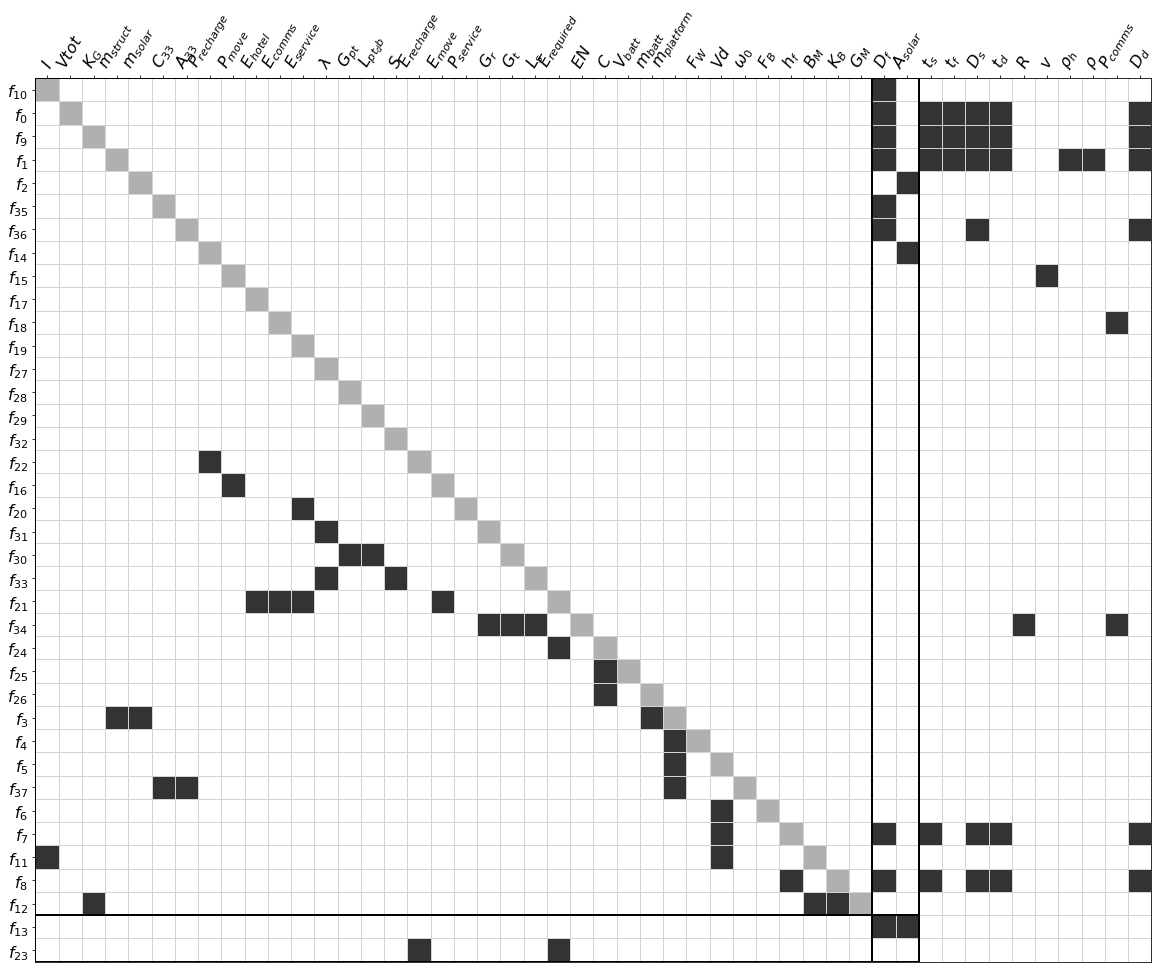

In [77]:
_, ax = render_incidence(edges_noparam, ntree, namingfunc2, figsize=(20,20))

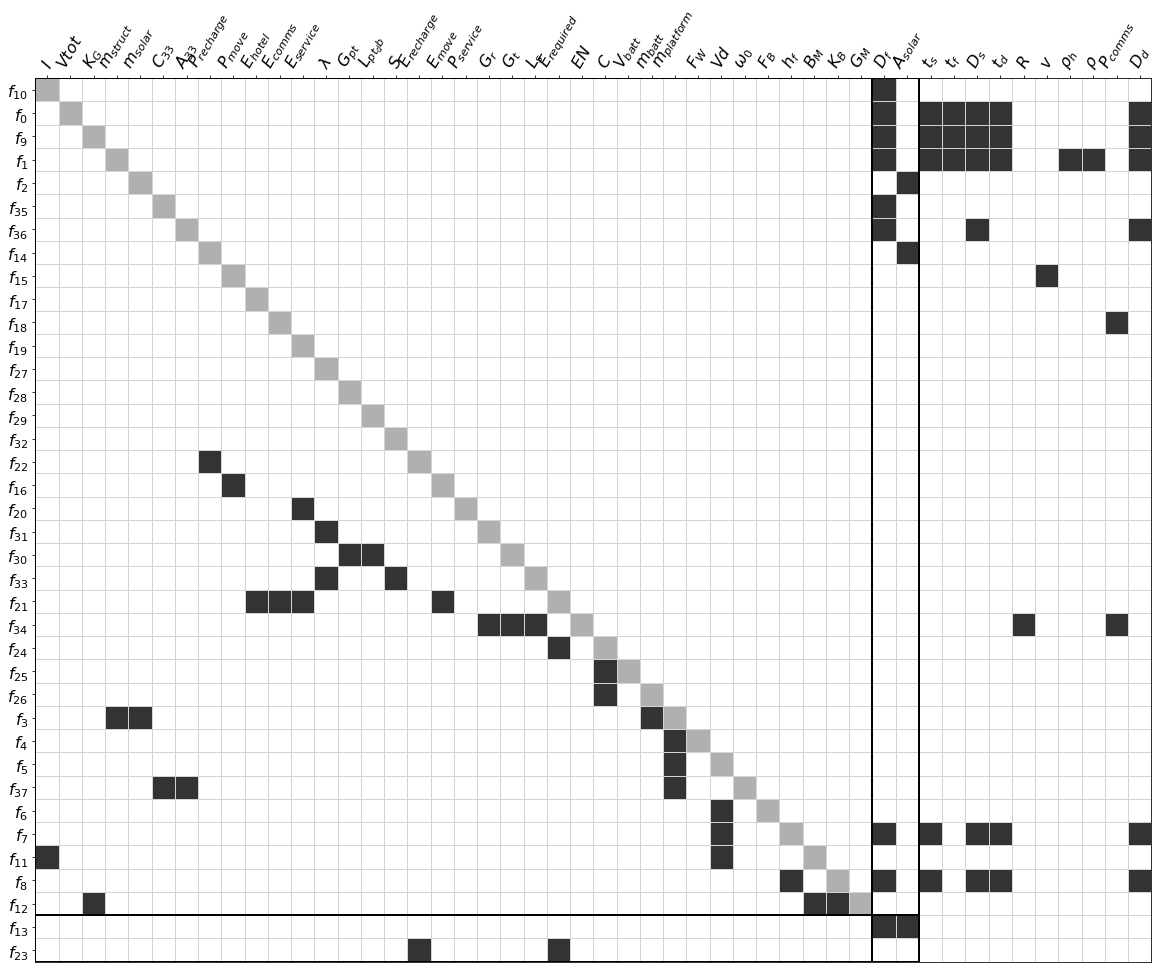

In [83]:
plt.sca(ax)
plt.savefig('pearl_with_end_comps.png', dpi=200, bbox_inches='tight')

# Run

In [58]:
DG = flat_graph_formulation(*edges)
merge_order = sort_scc(DG)
nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)

In [59]:
merge_order

[{f_10},
 {f_0},
 {f_9},
 {f_1},
 {f_2},
 {f_35},
 {f_36},
 {f_13},
 {f_14},
 {f_15},
 {f_17},
 {f_18},
 {f_19},
 {f_27},
 {f_28},
 {f_29},
 {f_32},
 {f_22},
 {f_16},
 {f_20},
 {f_31},
 {f_30},
 {f_33},
 {f_21},
 {f_34},
 {f_23},
 {f_24},
 {f_25},
 {f_26},
 {f_3},
 {f_4},
 {f_5},
 {f_37},
 {f_6},
 {f_7},
 {f_11},
 {f_8},
 {f_12}]

In [60]:
ordered_tree = ntree
ordered_edges = nedges
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options[1] = {'solver': 'N', 'maxiter':20}
#solvers_options[2] = {'solver': 'N', 'maxiter':20}
#solvers_options[3] = {'solver': 'N', 'maxiter':20}
nodetyperepr = model.nametyperepr
namingfunc = namefromsympy(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [61]:
components = model.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [62]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [63]:
prob.run_model()


==
s1
==
NL: Newton Converged in 6 iterations


In [64]:
prob.model.list_outputs();

88 Explicit Output(s) in 'model'

varname         val              
--------------  -----------------
inp
  d_deg         [0.005]          
  eta_parab     [0.55]           
  eta_m         [0.75]           
  D_d           [1.25]           
  eta_solar     [10.]            
  k             [1.38065e-23]    
  rho_w         [1023.6]         
  m_comms       [50.]            
  t_s           [2.]             
  theta         [55.]            
  I_deg         [0.9]            
  phi_s         [800.]           
  L_l           [0.79432823]     
  D_s           [1.]             
  e_t           [27.]            
  L_a           [0.9332543]      
  t_comms       [1.]             
  t_move        [1.]             
  t_mission     [24.]            
  t_recharge    [12.]            
  theta_t       [32.]            
  T_s           [135.]           
  R             [10.]            
  c             [3.e+08]         
  m_batt_zero   [5.]             
  nu_battery    [450.]           
  eta_A   

# Results

In [65]:
import pandas as pd

In [66]:
from compute import ureg
def prettyprintval(x):
    x = x[0]
    if abs(x)>1e4 or abs(x)<1e-3:
        return '{:.3e~P}'.format(ureg.Quantity(x, ''))
    else:
        return '{:.3f}'.format(x).rstrip('0').rstrip('.')
def prettyprintunit(x):
    if x.units != ureg('year'):
        strformat = '{:P~}'
        return strformat.format(x.units)
    else:
        return 'yr'

In [67]:
df = pd.DataFrame([(key, 
               prettyprintval(prob.get_val(namingfunc(key.varid, VAR))), 
               prettyprintunit(key.varunit)) for key,var in model.comp_by_var.items()])

In [68]:
dvars = {(elt,model.idmapping[elt].varval) for elt in mdao_in if not model.idmapping[elt].always_input}
pd.DataFrame(dvars)

,0,1
0,\rho_h,2700.00
1,t_s,2.00
2,D_d,1.25
3,R,10.00
4,t_f,0.50
5,t_d,0.50
6,P_{comms},0.50
7,v,1.00
8,\rho,700.00
9,D_s,1.00


In [69]:
df

,0,1,2
0,Vtot,7.383,m³
1,m_{struct},6395.539,kg
2,m_{solar},77.985,kg
3,m_{platform},6661.923,kg
4,F_W,6.535×10⁴,N
5,Vd,6.508,m³
6,F_B,6.535×10⁴,N
7,h_f,0.416,m
8,K_B,1.753,m
9,K_G,1.836,m


In [75]:
df.iloc[[12,13,21,35]]#.style.to_latex())

,0,1,2
12,G_M,1.239,m
13,P_{recharge},827.042,W
21,E_{recharge},9.925,hr·kW
35,\omega_0,3.414,rad/s
